# Figure 6, Expected gradients

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set figure aethetics
sns.set_context("notebook")
sns.set_style("ticks")

In [3]:
# Create a poisson spike train
def poisson(length, hz):
    p1 = [1. - hz / 1000., hz / 1000.]
    return np.random.choice([0., 1.], length, p=p1)

# Event-dependent scaling factor
def lmd(updated):
    if updated > 75:
        updated = 75
    return 1000 * (1. - np.exp(np.log(0.5) * (updated / 500.)**4))

# Calculate expected gradients for dv/dv_reset
def derivative(spike_train_1, spike_train_2, tau_m, use_lamda):
    dev = np.zeros_like(spike_train_1)
    kernel = np.exp(-np.arange(len(spike_train_1)) / tau_m)
    avg_1 = 0.
    avg_2 = 0.
    last_update = 0.
    for t, (spiked_1, spiked_2) in enumerate(zip(spike_train_1, spike_train_2)):
        if spiked_1:
            if not spiked_2:
                if use_lamda:
                    avg_1 += lmd(t - last_update) * dev[t]
                else:
                    avg_1 += dev[t]
                last_update = t
            dev[t:] += kernel[0:-(t)]
        if spiked_2 and not spiked_1:
            if use_lamda:
                avg_2 += lmd(t - last_update) * dev[t]
            else:
                avg_2 += dev[t]
            last_update = t
    return avg_1 / len(spike_train_1), avg_2 / len(spike_train_1)

## Expected gradient for poisson spike trains with varying firing rates

In [4]:
# Simulate
length = 300000
xs = np.linspace(1, 50, 16)
taus = [20., 30., 40., 50.]

all_avgs_1 = []
all_avgs_2 = []

for i, use_lamda in enumerate([False, True]):
    for tau_m in taus:
        avgs_1 = []
        avgs_2 = []
        for hz_1 in xs:
            np.random.seed(1)
            st_1 = poisson(length, hz_1)
            st_2 = poisson(length, 25.)
            avg_1, avg_2 = derivative(st_1, st_2, tau_m, use_lamda)
            avgs_1.append(avg_1)
            avgs_2.append(avg_2)
        all_avgs_1.append(avgs_1)
        all_avgs_2.append(avgs_2)

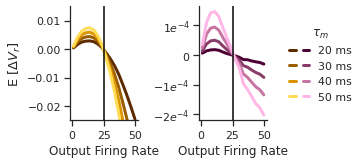

In [5]:
# Plot
colors_1 = sns.color_palette(['#5e2a00', '#9a5e00', '#dc9400', '#ffdc56'])
colors_2 = sns.color_palette(['#4d0033', '#8a3c69', '#c975a3', '#ffb7e7'])

colors = [colors_1, colors_2]

fig, axs = plt.subplots(1, 2, figsize=(4., 2.45))
for i, use_lamda in enumerate([False, True]):
    for j, tau_m in enumerate([20., 30., 40., 50.]):
        axs[i].plot(xs, np.asarray(all_avgs_2[j+i*len(taus)]) - np.asarray(all_avgs_1[j+i*len(taus)]), label=str(int(tau_m)) + " ms" if i == 1 else " ", color=colors[i][j], linewidth=3.)
    axs[i].axvline(25., color="k")
    axs[i].set_xlabel("Output Firing Rate")
    axs[i].set_xticks([0., 25., 50.])
axs[0].set_ylim(-0.025, 0.015)
axs[0].set_ylabel("E $[\Delta V_r]$", fontsize=13)
fig.legend(ncol=2, columnspacing=-.5, handlelength=0.6, title="$\\tau_m$", shadow=False, edgecolor="w", loc='center left', bbox_to_anchor=(.99, 0.6))

axs[1].set_yticks([-2e-4, -1e-4, 0, 1e-4])
axs[1].set_yticklabels(["$-2e^{-4}$", "$-1e^{-4}$", "$0$", "$1e^{-4}$"])
sns.despine()
fig.tight_layout()

fig.savefig("figure-6-a-b.svg", bbox_inches="tight")

## Expected gradient for correlated poisson spike trains

In [6]:
# Simulate
length = 300000
xs = np.linspace(1, 50, 16)

rolls = [-20, -10, -5, -1, 1, 5, 10, 20]
tau_m = 40.

all_avgs_1 = []
all_avgs_2 = []

for i, use_lamda in enumerate([False, True]):
    for roll in rolls:
        avgs_1 = []
        avgs_2 = []
        for hz_1 in xs:
            np.random.seed(1)
            st_1 = poisson(length, hz_1)
            avg_1, avg_2 = derivative(st_1, np.roll(st_1, roll), tau_m, use_lamda)
            avgs_1.append(avg_1)
            avgs_2.append(avg_2)
        all_avgs_1.append(avgs_1)
        all_avgs_2.append(avgs_2)

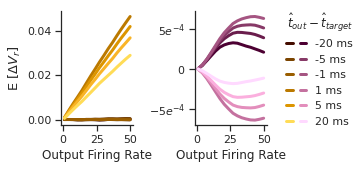

In [7]:
# Plot
colors_1 = sns.color_palette(['#450d00', '#5e2a00', '#7b4400', '#9a5e00', '#bb7900', '#dc9500', '#f9b427', '#ffdc57'])
colors_2 = sns.color_palette(['#4c0032', '#6a1d4c', '#873967', '#a55582', '#c4719f', '#e38ebc', '#fbafde', '#ffd9ff'])

colors = [colors_1, colors_2]

handles = []
fig, axs = plt.subplots(1, 2, figsize=(4., 2.45))
for i, use_lamda in enumerate([False, True]):
    for j, roll in enumerate(rolls):
        if np.abs(roll) != 10.:
            label = str(int(roll)) + " ms" if i == 1 else " "
        else:
            label = ""
        l = axs[i].plot(xs, np.asarray(all_avgs_2[j+i*len(rolls)]) - np.asarray(all_avgs_1[j+i*len(rolls)]), label=label, color=colors[i][j], linewidth=3.)[0]
        axs[i].set_xlabel("Output Firing Rate")
    axs[i].set_xticks([0., 25., 50.])
fig.legend(ncol=2, columnspacing=-.5, handlelength=0.6, title="$\hat{t}_{out} - \hat{t}_{target}$", shadow=False, edgecolor="w", loc='center left', bbox_to_anchor=(.98, 0.6))
axs[0].set_ylabel("E $[\Delta V_r]$", fontsize=13)
axs[1].set_yticks([-5e-4, 0, 5e-4])
axs[1].set_yticklabels(["$-5e^{-4}$", "$0$", "$5e^{-4}$"])

sns.despine()
fig.tight_layout()

fig.savefig("figure-6-c-d.svg", bbox_inches="tight")